In [4]:
import sys
print(sys.path)
sys.path.append("../KE/")
print(sys.path)

['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages']
['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages', '../KE/']


In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from KE.classifier.prepare import split_dataset
from KE.dataclean import tables

In [6]:
import random
import numpy as np
import os

In [2]:
RANDOM_SEED = 12
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

random_seed = random.seed
print(random.seed)
print(np.random.get_state())

<bound method Random.seed of <random.Random object at 0x150033010>>
('MT19937', array([        12,  274362557, 2871959443,   96505144, 3440553756,
       3320819264, 1671863157, 2853726411, 3576948821, 2267721719,
       1471449267,  205467717,  329644101, 2017124422,  120683281,
       3671631556, 3425389459, 2306138081, 2854342561, 2833917538,
       2139784180, 1777806526, 3803176561, 3129722129, 3441486743,
       1830495613, 3911788038,  683126036, 2275605760, 2143413223,
       1841233884, 3193124688, 3131946362,  854446201,  464715999,
       3543117598, 3696335765,  563062867, 3171341285, 2053716298,
       3493445055, 2373285717, 2744558717, 1005575494, 2549531338,
       3054493973,  794434881,  553407444, 3342173908, 2703770116,
       1986085520, 3203783784, 2832904198,  647337417,  715893123,
       2584083430,  191194412,  374961813, 3419702787, 3499023931,
       1892787284,  234508998, 1165532764, 2246131696,  884260026,
        627310499,   95884945,  105283704, 147383

In [7]:
data = pd.read_csv("../data/merged/merged-kg_edges.tsv", header=0, sep="\t")

/var/folders/7w/ksxs106s7_sg14v6cb2y70vr0000gn/T/ipykernel_77272/2785372968.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/merged/merged-kg_edges.tsv", header=0, sep="\t")


In [12]:
data_pairs = data[['subject','object']].drop_duplicates()
data_pairs

,subject,object
0,NCBITaxon:1,BFO:0000040
1,NCBITaxon:10,NCBITaxon:1706371
2,NCBITaxon:100,NCBITaxon:99
3,NCBITaxon:100,mediadive.medium:7
4,NCBITaxon:100,mediadive.medium:J346
...,...,...
1538345,NCBITaxon:147448,traits.cell_shape_enum:coccus
1538346,NCBITaxon:147448,ECOCORE:00000177
1538347,NCBITaxon:1240726,traits.cell_shape_enum:bacillus
1538348,NCBITaxon:1240783,traits.cell_shape_enum:bacillus


In [13]:
# Subset the DataFrame based on the substring in subject
data_pairs_clean = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
# Subset the DataFrame based on the substring in object
data_pairs_clean = data_pairs_clean[data_pairs_clean['object'].str.contains('mediadive.medium:')]
data_pairs_clean.to_csv("NCBITaxon_to_medium.tsv", sep="\t", header=True, index=False)
data_pairs_clean.shape

(32513, 2)

In [14]:
#TODO add closure

data_pairs_chem = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_chem = data_pairs_chem[data_pairs_chem['object'].str.contains('CHEBI:')]
data_pairs_chem.shape

(37667, 2)

In [15]:
#TODO add closure

data_pairs_go = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_go = data_pairs_go[data_pairs_go['object'].str.contains('GO:')]
data_pairs_go.shape

(2446, 2)

In [16]:
data_pairs_rest_all = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_rest = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('carbon_substrate:')]
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pathways:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_shape_enum:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('data_source:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('ENVO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('UBERON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest.shape

(47187, 2)

In [17]:
data_df_pairs = pd.concat([data_pairs_chem, data_pairs_go], ignore_index=True)
data_df_pairs = pd.concat([data_df_pairs, data_pairs_rest], ignore_index=True)

data_df_pairs['Value'] = 1

# Step 2: Pivot the old DataFrame to form the new DataFrame structure
data_df = data_df_pairs.pivot(index='subject', columns='object', values='Value')

# Step 3: Fill NaN values with 0 to indicate no relationship
data_df = data_df.fillna(0)

# Optionally, convert the filled NaN values to integers if they were floats after pivot
data_df = data_df.astype(int)
data_df

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_oxidation,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
subject_object_mapping = data_pairs_clean.set_index('subject')['object'].to_dict()

# Use the map function to create a new column in 'new_dataframe' from the 'subject' indices
data_df['medium'] = data_df.index.map(subject_object_mapping)


In [19]:
data_df['medium'].isna().sum()

20368

In [20]:
data_df = data_df[data_df['medium'].notna()]
data_df

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,mediadive.medium:81
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:110
NCBITaxon:1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:668
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:92
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J118
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514


In [21]:
#data_pairs_clean = tables.rows_ad_cols_quant_filter(data_pairs)
#require at least 10 examples per class
data_df_clean = data_df.groupby('medium').filter(lambda x : len(x)>9)
data_df_clean

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:110
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:92
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J14
NCBITaxon:1002368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J12
NCBITaxon:1002526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J118
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514


In [22]:
import pickle

#DeepWalkSkipGramEnsmallen_degreenorm_embedding_2023-11-29_10_24_15.pkl
#DeepWalkSkipGramEnsmallen_degreenorm_embedding_2024-01-08_00_23_18.pkl
pickle_filename = 'DeepWalkSkipGramEnsmallen_degreenorm_embedding_2024-01-08_00_23_18.pkl'

with open(pickle_filename, 'rb') as file:
    # Use the 'rb' mode to read in binary mode
    DeepWalkSkipGramEnsmallen_degreenorm_embedding = pickle.load(file)

/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
type(DeepWalkSkipGramEnsmallen_degreenorm_embedding)


embiggen.utils.abstract_models.embedding_result.EmbeddingResult

In [24]:
node_embed = DeepWalkSkipGramEnsmallen_degreenorm_embedding.get_all_node_embedding()[0]

In [25]:
node_embed2 = DeepWalkSkipGramEnsmallen_degreenorm_embedding.get_all_node_embedding()[1]

In [26]:
type(node_embed)

pandas.core.frame.DataFrame

In [27]:
node_embed


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
NCBITaxon:1000003,-1.031455,1.349113,1.899774,-0.946336,-0.109856,-1.593317,-1.848653,-0.062838,2.012377,1.241247,...,-0.479338,0.196126,2.574927,0.329952,0.043694,0.019184,-0.231998,-1.139623,-0.812228,1.687592
NCBITaxon:1000010,-1.157560,1.225671,0.580858,1.201925,-0.718344,-1.292087,-1.950941,-2.336847,1.339372,-1.365434,...,-1.155502,1.589112,0.693132,-0.746466,-1.932839,0.734429,-0.395581,-1.539705,-2.177659,0.478125
NCBITaxon:1000018,-2.505306,-1.925052,0.932496,-0.718516,1.207053,-1.530640,-1.440780,0.547364,-1.201462,1.486149,...,0.110403,0.416665,1.319849,2.196532,0.006788,-0.624915,1.991254,-1.983693,2.009059,0.663362
NCBITaxon:1000025,-1.082069,-0.767280,1.703067,-0.904418,-0.203546,-0.306053,-3.343982,-0.781077,1.511115,-0.674152,...,-0.333874,-2.003359,1.099833,2.473160,-2.325198,1.050515,0.582174,-1.295575,-0.671583,-0.050192
NCBITaxon:1000032,2.325878,1.584836,2.900095,-1.365675,-0.001004,-2.111284,-2.778858,0.237287,-1.709499,-0.305866,...,-1.601846,0.405566,1.550465,0.972813,-0.591192,0.754095,-0.079234,-3.035640,-0.218694,0.483170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:1659714,0.775793,-0.679273,0.092945,-0.048980,0.397659,0.614983,-0.502394,-0.500043,1.399469,0.221401,...,-0.084529,-0.068886,0.804680,-0.149316,0.027359,0.376390,0.335816,-1.904072,-0.194623,0.076194
NCBITaxon:1870946,1.050766,-0.580509,0.258101,0.504690,1.080931,0.220780,-1.228080,-0.117243,1.517538,0.180042,...,0.575155,-0.005054,1.095349,0.270433,-0.270216,0.596595,0.201780,-2.196196,-0.409648,0.082531
NCBITaxon:1870956,0.670182,-0.607658,-0.074437,0.480364,0.486737,0.750590,-1.025770,-0.774118,1.334956,0.296615,...,-0.003220,-0.028009,0.600880,0.036342,0.093275,0.545338,0.203868,-2.020937,0.245998,-0.318171
NCBITaxon:1967661,0.904905,-0.498616,-0.421741,0.243026,0.412067,0.728597,-0.875614,-0.539034,1.267377,0.087819,...,-0.344265,-0.407782,1.151033,0.171674,-0.133862,0.878476,0.008379,-1.762125,0.271346,-0.086053


In [28]:
node_embed2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
NCBITaxon:1000003,-0.851284,0.988857,0.371988,-1.214423,0.268440,0.415412,1.156210,3.355280,0.595030,2.313853,...,1.857498,-1.404233,-0.263133,-1.065219,0.319012,-0.311994,0.958230,3.430695,0.509267,1.592615
NCBITaxon:1000010,-0.829608,1.244923,-1.224069,0.476604,-0.947860,0.627461,0.869151,0.402238,0.197349,-0.401606,...,0.419021,0.421658,-1.251403,-1.795962,-1.580469,0.866128,0.632690,2.538226,-0.402535,0.114112
NCBITaxon:1000018,-2.184090,-2.246455,-0.275248,-1.365230,0.978455,0.640932,1.945370,4.054640,-2.357964,2.762495,...,2.169084,-1.206666,-1.090588,0.582834,0.581564,-1.147194,2.670822,2.548922,3.287714,0.368422
NCBITaxon:1000025,-0.732894,-1.169684,0.234325,-0.850819,0.017477,1.641452,0.107905,2.603926,0.010028,0.617788,...,2.087486,-3.625146,-1.904850,0.770218,-1.823285,0.713638,1.886540,3.502179,1.058140,0.029119
NCBITaxon:1000032,3.059520,1.342080,1.604109,-1.334065,0.015293,-0.523136,0.756624,3.455146,-3.216451,0.835972,...,0.265562,-1.056380,-1.488469,-0.743376,0.029394,0.374867,1.028236,1.747947,1.130074,0.605635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:1659714,1.243117,-0.947247,-1.173451,-0.129000,0.579661,1.990377,1.568887,1.804997,0.836340,0.826854,...,1.538858,-1.052069,-1.159192,-1.298251,-0.026122,0.498160,1.337344,1.443885,1.448357,0.287928
NCBITaxon:1870946,1.721317,-1.331585,-0.380885,0.199079,1.057520,1.352228,0.816803,2.050873,0.692222,0.598289,...,1.916509,-0.962924,-1.572387,-1.105794,-0.263860,0.346044,1.662415,1.505355,1.524117,0.331351
NCBITaxon:1870956,1.853584,-1.377037,-0.807550,0.109291,1.025742,2.130585,0.881312,1.619169,0.796440,0.537708,...,1.660294,-1.096766,-1.666212,-1.308544,0.241269,0.294879,1.871052,1.288712,1.587830,-0.404584
NCBITaxon:1967661,1.434538,-1.525860,-1.160817,-0.149080,0.347281,1.425932,0.928340,1.587843,1.054680,0.743261,...,1.539290,-1.178815,-1.249957,-0.754260,-0.100542,0.849967,1.272003,1.876271,1.900160,0.189842


In [29]:
data_df_clean_join_embed = data_df_clean.join(node_embed, how='left')
data_df_clean_join_embed

,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,90,91,92,93,94,95,96,97,98,99
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,-1.273403,-0.285484,2.894019,-0.588553,0.304278,-1.362631,1.137794,-1.717054,-1.512253,0.825833
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,-1.679868,2.347212,1.442551,1.449241,-0.497471,-2.567467,0.990777,-3.253783,-0.956055,-2.034431
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,-0.967366,0.464502,2.348836,-0.078550,-0.552918,-0.208043,1.133552,-1.544743,-1.716866,1.727506
NCBITaxon:1002368,0,0,0,0,0,0,0,0,0,0,...,0.258961,-1.683862,0.433024,0.270735,-2.204029,-2.115252,1.392747,-1.801429,-1.007289,-0.213884
NCBITaxon:1002526,0,0,0,0,0,0,0,0,0,0,...,-0.650318,0.503423,0.621382,-1.162862,-0.616592,-2.902317,-0.176856,-0.442447,-2.165668,-0.081635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,-1.501310,1.978770,0.944935,1.213805,-1.344280,-1.493057,-0.964690,-1.045901,-1.638690,-0.166088
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,-0.989938,0.802619,1.274777,0.600908,-0.676428,-1.974637,-2.023367,0.059113,-0.978106,0.161313
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,-2.326306,2.900110,-0.493073,1.381404,-1.819567,-1.161649,-0.548093,-0.653385,-0.070399,0.790302


In [30]:
data_df_clean_join_embed2 = data_df_clean_join_embed.join(node_embed2, how='left', lsuffix='_left', rsuffix='_right')
data_df_clean_join_embed2

,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,90_right,91_right,92_right,93_right,94_right,95_right,96_right,97_right,98_right,99_right
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0.162629,-2.273246,-0.231700,-1.809598,0.860964,-1.626807,2.129407,2.420233,-0.656849,1.032531
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,1.029343,0.536299,-1.034751,0.200735,0.113141,-2.872515,2.464246,1.199523,0.352270,-1.801784
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,0.960424,-0.780511,-0.646330,-1.586410,0.755049,-0.351068,2.620379,2.629001,-0.215337,3.405646
NCBITaxon:1002368,0,0,0,0,0,0,0,0,0,0,...,1.928981,-2.795320,-1.476254,-1.480178,-1.754710,-1.293914,2.666051,2.554238,0.308699,-0.621719
NCBITaxon:1002526,0,0,0,0,0,0,0,0,0,0,...,1.467282,-1.093064,-1.852053,-2.578706,-0.392165,-3.214552,1.285937,3.742419,-0.830021,-0.444085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,0.102631,0.961337,-2.303350,-0.663034,-0.939560,-1.645375,0.523637,3.258208,-0.141849,-0.063511
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,-0.049724,-0.516063,-1.122472,-0.143546,-0.048471,-2.532022,-0.995582,4.884026,0.669134,0.102672
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0.070490,1.371192,-4.092691,-0.763367,-1.182081,-1.621842,1.111404,4.208204,1.606825,0.705671


In [31]:
# Splitting the data into features and target labels
X = data_df_clean_join_embed2.drop('medium', axis=1)#data_pairs_clean[['subject']]
y = data_df_clean_join_embed2['medium']

# Convert the input labels column to a categorical type if it isn't
#X['subject'] = X['subject'].astype('category')

# Convert categorical columns to integers
#X['subject'] = X['subject'].cat.codes

In [33]:
len(set(data_df_clean_join_embed2['medium']))

105

In [34]:
len(set(data_df['medium']))

1419

In [35]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_SEED)

train_data = Pool(data=X_train, label=y_train, cat_features=[0])
val_data = Pool(data=X_val, label=y_val, cat_features=[0])
test_data = Pool(data=X_test, label=y_test, cat_features=[0])

In [36]:
#6908
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4122, 467)
(1374, 467)
(1374, 467)


In [37]:
## Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
## Train the model
#train_data = Pool(data=X_train, label=y_train, cat_features=[0])
#test_data = Pool(data=X_test, label=y_test, cat_features=[0])


In [39]:
%%time
#only feature data (no embeddings) and below params = Accuracy: 0.3125904486251809
model = CatBoostClassifier(random_seed=RANDOM_SEED,
                           iterations=10000, 
                           loss_function="MultiClass",
                           learning_rate=0.1, 
                           depth=4,#8 = 0.238 
                           l2_leaf_reg=3,
                           bagging_temperature=1,
                           random_strength=5,
                           verbose=100)
model.fit(train_data, 
          eval_set=val_data,
          early_stopping_rounds=50 
         )#, plot=True)

0:	learn: 4.4307269	test: 4.4478353	best: 4.4478353 (0)	total: 604ms	remaining: 1h 40m 39s
100:	learn: 1.3831893	test: 1.9241569	best: 1.9241569 (100)	total: 28.7s	remaining: 46m 51s
200:	learn: 0.8076097	test: 1.5126822	best: 1.5126822 (200)	total: 56.7s	remaining: 46m 6s
300:	learn: 0.6039721	test: 1.3698211	best: 1.3698211 (300)	total: 1m 25s	remaining: 45m 47s
400:	learn: 0.4894010	test: 1.3016422	best: 1.3016422 (400)	total: 1m 53s	remaining: 45m 12s
500:	learn: 0.4122232	test: 1.2590094	best: 1.2590094 (500)	total: 2m 21s	remaining: 44m 49s
600:	learn: 0.3547127	test: 1.2314271	best: 1.2314056 (599)	total: 2m 49s	remaining: 44m 13s
700:	learn: 0.3138683	test: 1.2141364	best: 1.2140240 (696)	total: 3m 17s	remaining: 43m 46s
800:	learn: 0.2767717	test: 1.2003501	best: 1.2003501 (800)	total: 3m 45s	remaining: 43m 13s
900:	learn: 0.2454156	test: 1.1876788	best: 1.1875774 (899)	total: 4m 13s	remaining: 42m 42s
1000:	learn: 0.2180772	test: 1.1780346	best: 1.1780346 (1000)	total: 4m 41s

In [40]:
# Predict on test data
y_pred = model.predict(test_data)
y_pred_proba = model.predict_proba(test_data)[:,1]  # Probabilities for the positive class

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.5786026200873362

Classification Report:
                         precision    recall  f1-score   support

    mediadive.medium:1       0.51      0.58      0.55        72
  mediadive.medium:104       0.60      0.63      0.62        19
 mediadive.medium:104b       0.83      0.83      0.83         6
 mediadive.medium:104c       1.00      0.67      0.80         3
mediadive.medium:1076b       1.00      1.00      1.00         9
   mediadive.medium:11       0.81      0.84      0.83        31
  mediadive.medium:110       0.71      0.56      0.63         9
  mediadive.medium:119       0.50      0.33      0.40         3
 mediadive.medium:1203       1.00      0.33      0.50         3
mediadive.medium:1203a       0.00      0.00      0.00         3
  mediadive.medium:141       0.75      1.00      0.86         3
  mediadive.medium:144       1.00      0.50      0.67         2
 mediadive.medium:1523       0.67      0.67      0.67         3
  mediadive.medium:193       1.00      1.00      

/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

In [41]:
# Predict on train data
y_pred_train = model.predict(train_data)
y_pred_proba_train = model.predict_proba(train_data)[:,1]  # Probabilities for the positive class

# Print metrics                                                                                                                        
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 1.0

Classification Report:
                         precision    recall  f1-score   support

    mediadive.medium:1       1.00      1.00      1.00       215
  mediadive.medium:104       1.00      1.00      1.00        57
 mediadive.medium:104b       1.00      1.00      1.00        18
 mediadive.medium:104c       1.00      1.00      1.00         8
mediadive.medium:1076b       1.00      1.00      1.00        28
   mediadive.medium:11       1.00      1.00      1.00        90
  mediadive.medium:110       1.00      1.00      1.00        29
  mediadive.medium:119       1.00      1.00      1.00         8
 mediadive.medium:1203       1.00      1.00      1.00         8
mediadive.medium:1203a       1.00      1.00      1.00         9
  mediadive.medium:141       1.00      1.00      1.00        11
  mediadive.medium:144       1.00      1.00      1.00         7
 mediadive.medium:1523       1.00      1.00      1.00        10
  mediadive.medium:193       1.00      1.00      1.00         6


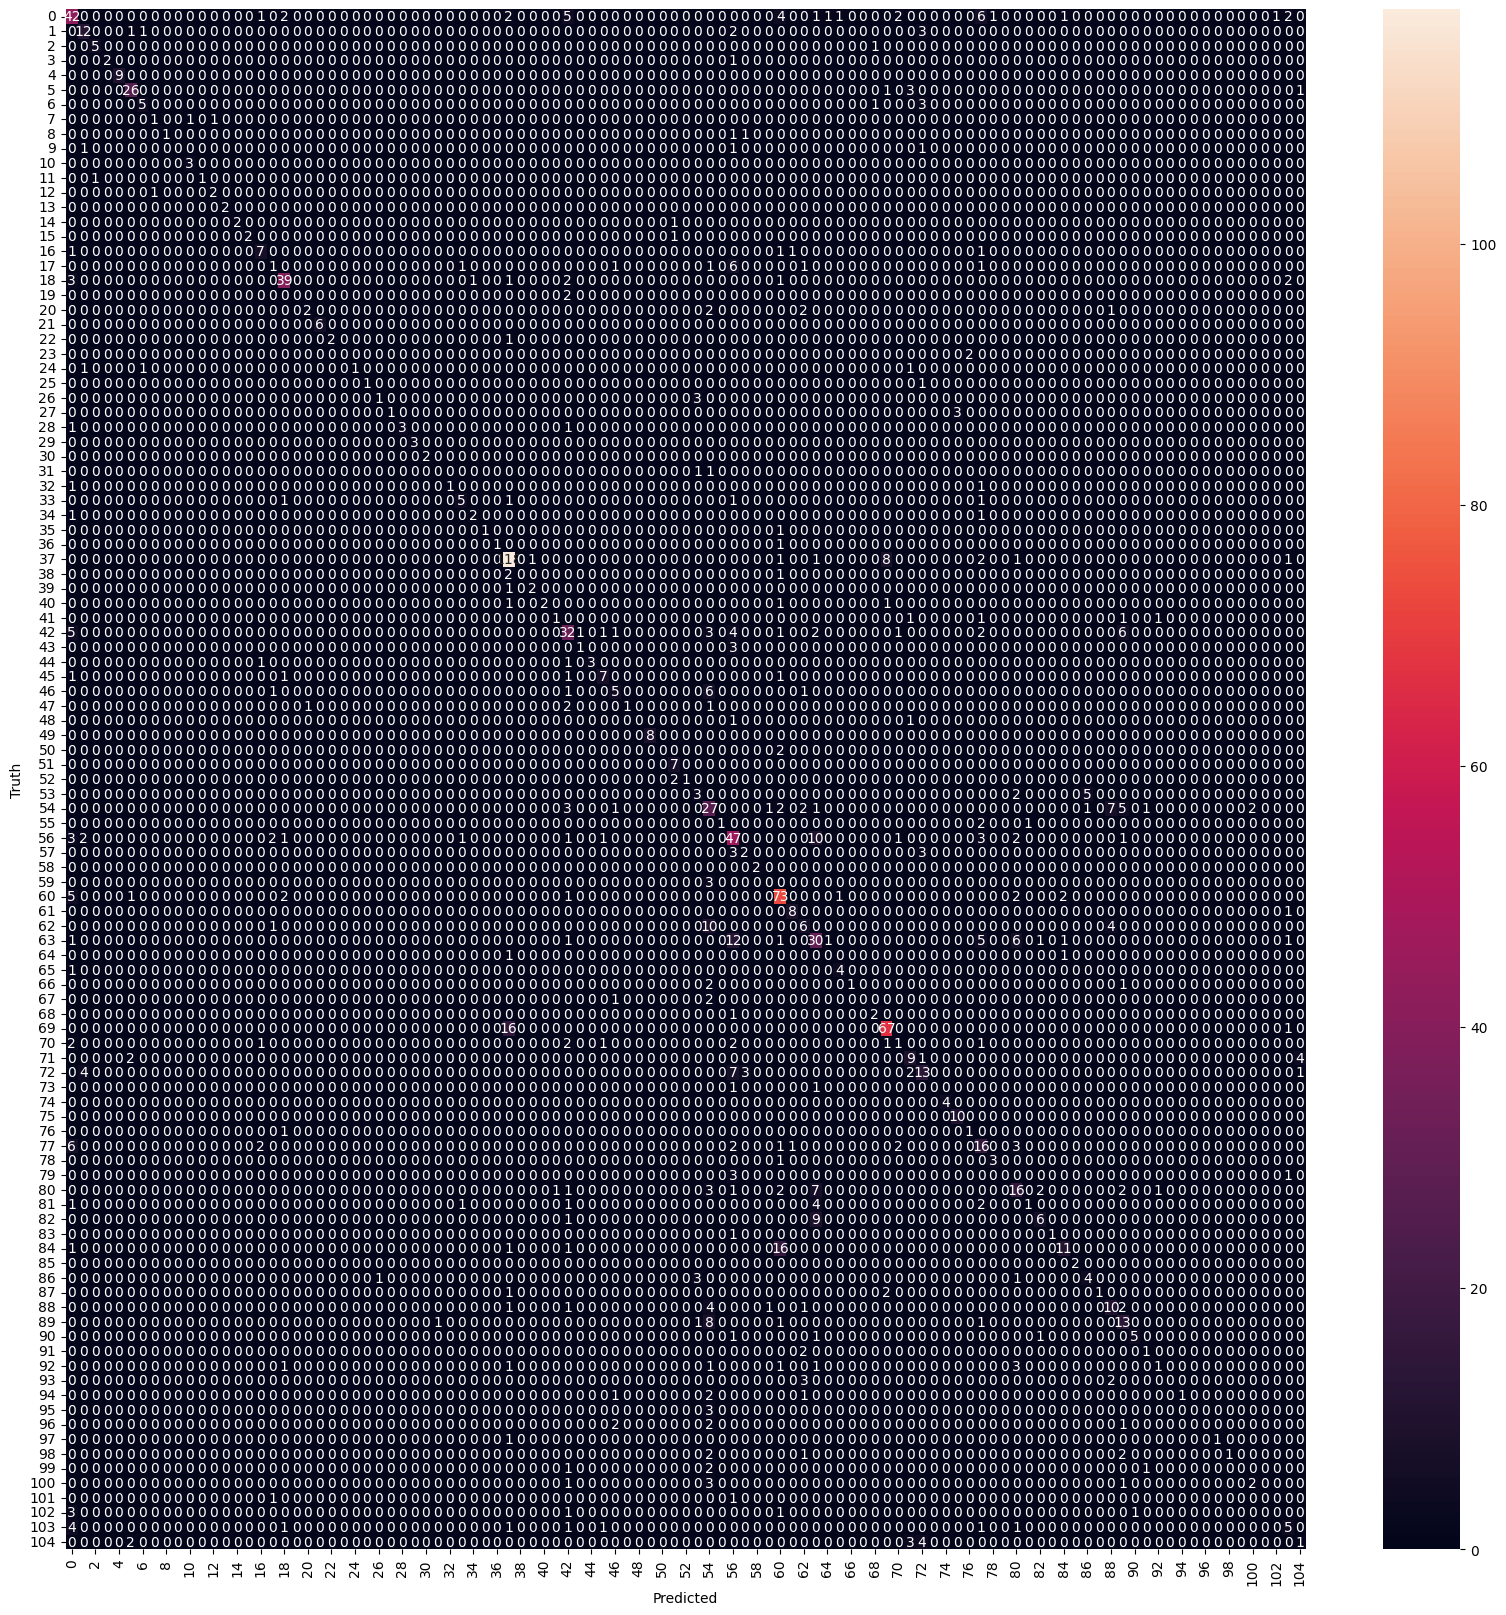

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# True labels are assumed to be in y_test
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('20231201_wembedding_test_confusion_matrix.pdf', format='pdf')
plt.show()